In [1]:
!pip install pyspark flask scikit-learn pandas xgboost lightgbm

In [2]:
# Install required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Load data
def load_data(file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)

data = load_data("/content/synthetic_fraud_dataset.csv")

data.show(50)

+--------------------+---------+------------------+----------------+-------------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+----------+--------+--------------------+---------------------+----------+----------+-----------+
|      Transaction_ID|  User_ID|Transaction_Amount|Transaction_Type|          Timestamp|Account_Balance|Device_Type|Location|Merchant_Category|IP_Address_Flag|Previous_Fraudulent_Activity|Daily_Transaction_Count|Avg_Transaction_Amount_7d|Failed_Transaction_Count_7d| Card_Type|Card_Age|Transaction_Distance|Authentication_Method|Risk_Score|Is_Weekend|Fraud_Label|
+--------------------+---------+------------------+----------------+-------------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+------

In [3]:
# Handle missing values
def handle_missing_values(df):
    return df.dropna()

data = handle_missing_values(data)

data.show()

+--------------------+---------+------------------+----------------+-------------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+----------+--------+--------------------+---------------------+----------+----------+-----------+
|      Transaction_ID|  User_ID|Transaction_Amount|Transaction_Type|          Timestamp|Account_Balance|Device_Type|Location|Merchant_Category|IP_Address_Flag|Previous_Fraudulent_Activity|Daily_Transaction_Count|Avg_Transaction_Amount_7d|Failed_Transaction_Count_7d| Card_Type|Card_Age|Transaction_Distance|Authentication_Method|Risk_Score|Is_Weekend|Fraud_Label|
+--------------------+---------+------------------+----------------+-------------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+------

In [4]:
# Handle imbalanced dataset
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def balance_data(df):
    pdf = df.toPandas()
    # Exclude 'Transaction_ID', 'Fraud_Label', AND 'user_id' from features
    X = pdf.drop(columns=["Fraud_Label", "Transaction_ID", "User_ID"])
    y = pdf["Fraud_Label"]
    user_ids = pdf["User_ID"]  # Store user_id separately

    # Identify and encode categorical features
    for col in X.select_dtypes(include=['object', 'datetime']).columns: # Include 'datetime' for DateTime columns
        if pd.api.types.is_datetime64_any_dtype(X[col]): # Handle DateTime columns differently
            X[col] = X[col].astype(int) / 10**9 # Convert to Unix timestamp (seconds)
        else:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])

    smote = SMOTE(sampling_strategy=0.5)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Include 'Transaction_ID' AND 'user_id' back in the final DataFrame
    X_resampled['Transaction_ID'] = pdf['Transaction_ID']
    X_resampled['User_ID'] = user_ids  # Add user_id back

    return spark.createDataFrame(pd.concat([X_resampled, y_resampled], axis=1))

data = balance_data(data)
data.show()

+------------------+----------------+------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+---------+--------+--------------------+---------------------+----------+----------+--------------------+---------+-----------+
|Transaction_Amount|Transaction_Type|   Timestamp|Account_Balance|Device_Type|Location|Merchant_Category|IP_Address_Flag|Previous_Fraudulent_Activity|Daily_Transaction_Count|Avg_Transaction_Amount_7d|Failed_Transaction_Count_7d|Card_Type|Card_Age|Transaction_Distance|Authentication_Method|Risk_Score|Is_Weekend|      Transaction_ID|  User_ID|Fraud_Label|
+------------------+----------------+------------+---------------+-----------+--------+-----------------+---------------+----------------------------+-----------------------+-------------------------+---------------------------+---------+--------+--------------------+--------------------

## 2. Exploratory Data Analysis (EDA)

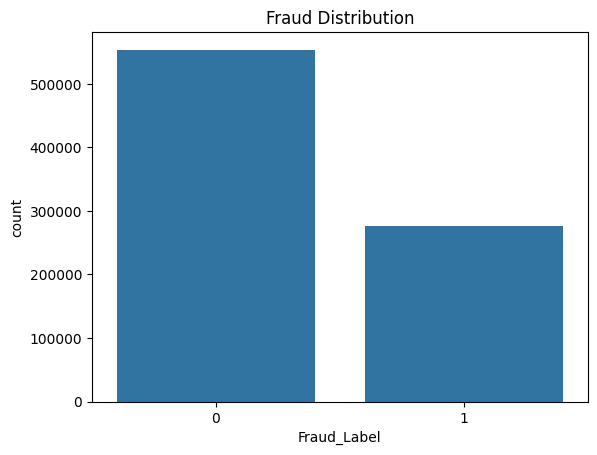

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fraud_distribution(df):
    pdf = df.toPandas()
    sns.countplot(x='Fraud_Label', data=pdf)
    plt.title("Fraud Distribution")
    plt.show()

plot_fraud_distribution(data)

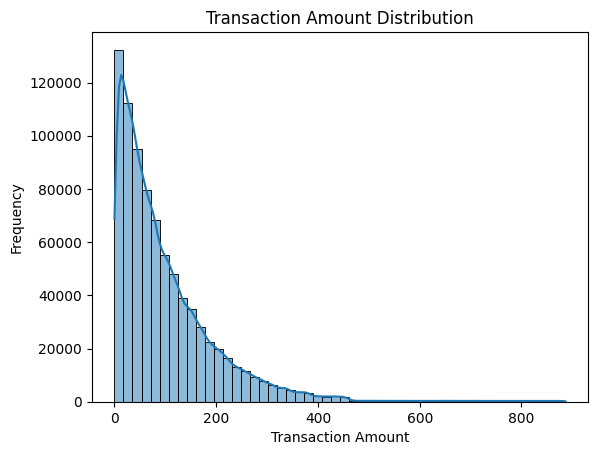

In [6]:
def transaction_amount_distribution(df):
    pdf = df.toPandas()
    sns.histplot(pdf['Transaction_Amount'], bins=50, kde=True)
    plt.title("Transaction Amount Distribution")
    plt.xlabel("Transaction Amount")
    plt.ylabel("Frequency")
    plt.show()

transaction_amount_distribution(data)

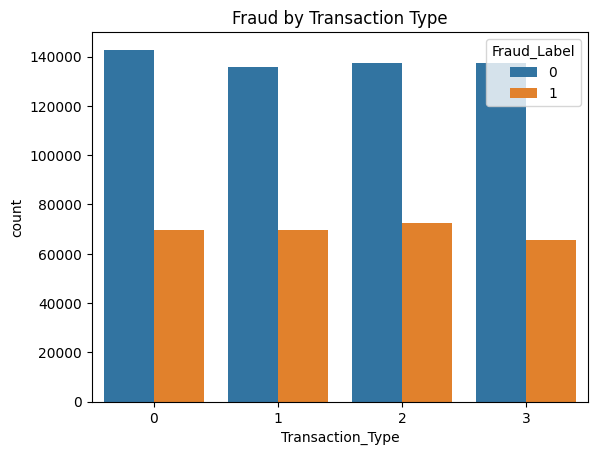

In [7]:
def fraud_by_transaction_type(df):
    pdf = df.toPandas()
    sns.countplot(x='Transaction_Type', hue='Fraud_Label', data=pdf)
    plt.title("Fraud by Transaction Type")
    plt.show()

fraud_by_transaction_type(data)

## 3. Feature Engineering

In [10]:
from pyspark.ml.feature import VectorAssembler

def feature_engineering(df):
    feature_cols = ["Transaction_Amount", "Account_Balance", "IP_Address_Flag", "Previous_Fraudulent_Activity", "Daily_Transaction_Count", "Avg_Transaction_Amount_7d", "Failed_Transaction_Count_7d", "Card_Age", "Transaction_Distance", "Risk_Score", "Is_Weekend"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df).select("features", "Fraud_Label")
    return df

data = feature_engineering(data)
data.show()

+--------------------+-----------+
|            features|Fraud_Label|
+--------------------+-----------+
|[137.23,76326.69,...|          0|
|[55.48,11912.16,0...|          0|
|[16.1,71687.05,0....|          0|
|[8.06,27737.57,0....|          0|
|[18.65,58851.6,0....|          0|
|[36.41,6795.6,0.0...|          0|
|[378.34,18226.54,...|          0|
|[355.9,76331.51,1...|          0|
|[55.49,6075.18,0....|          1|
|[32.11,20128.87,0...|          1|
|[230.5,6807.69,0....|          1|
|[16.31,94536.72,0...|          0|
|[2.78,87670.38,0....|          0|
|[212.45,89857.76,...|          0|
|[2.26,76408.61,0....|          1|
|[47.51,50568.34,0...|          1|
|[69.95,99033.33,0...|          0|
|[141.44,36595.18,...|          0|
|[20.44,70567.77,0...|          0|
|[30.63,18754.89,0...|          0|
+--------------------+-----------+
only showing top 20 rows



## 4. Model Selection and Training

In [12]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id
import pandas as pd
import numpy as np

# Train-Test Split
train_data, test_data = data.randomSplit([0.8, 0.2])

# Initialize Models
rf = RandomForestClassifier(labelCol="Fraud_Label", featuresCol="features", numTrees=100)
gbt = GBTClassifier(labelCol="Fraud_Label", featuresCol="features")
knn = KNeighborsClassifier(n_neighbors=5)

# Train Models
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)

# Convert train_data to pandas DataFrame for KNN
train_pd = train_data.toPandas()
# Extract features and target variable
X_train = train_pd["features"].apply(lambda x: np.array(x.toArray())).to_numpy()
X_train = np.vstack(X_train)  # Reshape to 2D array
y_train = train_pd["Fraud_Label"].to_numpy()
# Train KNN model
knn_model = knn.fit(X_train, y_train)

# Evaluate Models
def evaluate_model(model, test_data):
    evaluator = BinaryClassificationEvaluator(labelCol="Fraud_Label")
    auc = evaluator.evaluate(model.transform(test_data))
    return auc

models = {"RandomForest": rf_model, "GradientBoostedTree": gbt_model, "KNN": knn_model}

best_model_name, best_model, best_auc = None, None, 0
for name, model in models.items():
    # Handle KNN model evaluation separately
    if name == "KNN":
        # Convert test_data to pandas DataFrame for KNN
        test_pd = test_data.toPandas()
        # Extract features and target variable
        X_test = test_pd["features"].apply(lambda x: np.array(x.toArray())).to_numpy()
        X_test = np.vstack(X_test)  # Reshape to 2D array
        y_test = test_pd["Fraud_Label"].to_numpy()

        # Evaluate using sklearn metrics
        from sklearn.metrics import roc_auc_score
        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        auc = evaluate_model(model, test_data)

    print(f"{name} Model AUC: {auc}")
    if auc > best_auc:
        best_model_name, best_model, best_auc = name, model, auc

print(f"Best Model: {best_model_name} with AUC: {best_auc}")

RandomForest Model AUC: 0.9749695238551658
GradientBoostedTree Model AUC: 0.9819740606386695
KNN Model AUC: 0.5060068310418719
Best Model: GradientBoostedTree with AUC: 0.9819740606386695


### 5. Model Deployment using Flask

In [14]:
!pip install flask flask_bootstrap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for flask_bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460122 sha256=f22049b30bcf6536c693a3ea963ab6fccbba2f2fcb3718181ac099ef4507b5b9
  Stored in directory: /root/.cache/pip/wheels/3a/a2/90/8d658b1e875f36bdad71cdece9598b08c465d44bea13b9f74c
  Created wheel for visitor: filename=visitor-0.1.3-py3-none-any.whl size=3928 sha256=3067765a3da3eac25333dfede9ebebd29c274fdd9d7b84b68e228c075da34b90
  Stored in directory: /root/.cache/pip/wheels/a6/7c/bb/66bee1b6af18bb643ec4e26a58e932c6373849f1f1918592fd
Successfully built flask_bootstrap visitor


In [20]:
from flask import Flask, request, jsonify, render_template
from flask_bootstrap import Bootstrap
import pickle

app = Flask(__name__)

def predict_fraud(features):
    prediction = best_model.transform(features).select("prediction").collect()[0][0]
    return prediction

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = spark.createDataFrame([data])
    prediction = predict_fraud(features)
    return jsonify({'fraud_prediction': prediction})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


### 6. Monitoring and Maintenance

In [19]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def log_predictions(features, prediction):
    log_message = f'Prediction: {prediction}, Features: {features}'
    logging.info(log_message)
    print(log_message)  # Print the prediction result

# Example logging usage
log_predictions({'Transaction_Amount': 200, 'Account_Balance': 50000, 'IP_Address_Flag': 0}, 1)


Prediction: 1, Features: {'Transaction_Amount': 200, 'Account_Balance': 50000, 'IP_Address_Flag': 0}
